In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from typing import Dict, Union
from typing import Optional, Tuple

import joblib

In [3]:
TARGET_FEATURES = ['is_churn', 'is_keep','is_upgrade', 'churn_target', 'multiclass_target', 'churn_target_names', 'multiclass_target_names', 'churn_target']
IGNORE_FEATURES = ['gym', 'user', 'communication_date', 'heuristic_prediction']

# Load data

- The "train.xlxs" here is the past user's data
- The "submission.xlsx" is the "application" file you sent to me.

In [4]:
train_data = pd.read_excel('../data/raw/train.xlsx')
submission_data = pd.read_excel('../data/raw/submission.xlsx')
train_data

,communication_date,gym,gym_category,gym_days_since_first_visit,gym_last_60_days_visits,gyms_5km,is_churn,is_keep,is_upgrade,user,user_age,user_billings,user_days_since_first_billing,user_days_since_first_gym_visit,user_days_since_first_visit,user_last_60_days_visit_share,user_last_60_days_visits,user_lifetime_visit_share,user_lifetime_visits,user_plan
0,2021-10-25,0,bodybuilding,472,3751,35,0,1,0,0,50,13,1833.0,346,1833,5.263158e+15,19,1.170213e+16,94.0,Silver
1,2021-06-20,1,not found,2176,357,7,0,1,0,1,45,87,2608.0,54,1719,1.000000e+00,2,6.153846e+15,325.0,Basic II
2,2021-10-25,2,bodybuilding,895,3132,41,0,1,0,2,27,9,271.0,264,271,1.162791e+16,43,1.206030e+16,199.0,Basic I
3,2021-10-25,3,bodybuilding,896,4775,42,0,1,0,3,29,9,271.0,268,271,1.627907e+16,43,1.557789e+16,199.0,Basic I
4,2021-12-12,4,not found,1516,503,65,0,0,1,4,22,20,729.0,726,726,1.000000e+00,29,1.000000e+00,119.0,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31256,2021-12-04,19,not found,144,14979,28,0,0,1,31256,22,2,25.0,24,24,2.500000e-01,4,2.500000e-01,4.0,Silver
31257,2021-12-04,19,not found,144,14979,28,1,0,0,31257,66,1,19.0,19,19,1.000000e+00,1,1.000000e+00,1.0,Silver
31258,2021-12-11,109,bodybuilding,1062,1466,69,0,1,0,31258,42,1,25.0,12,24,2.500000e-01,8,2.500000e-01,8.0,Silver
31259,2022-01-17,50,crossfit,1500,780,30,0,1,0,31259,37,3,56.0,55,55,5.625000e+03,16,5.625000e+03,16.0,Silver


# Preprocessing

In [5]:
from helper import *
%load_ext autoreload
%autoreload 2

In [6]:
# features
train_data = preprocessing(train_data)

In [7]:
FEATURES = get_features(train_data, TARGET_FEATURES, IGNORE_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(train_data[FEATURES]))
CATEGORICAL_FEATURES = sorted(get_categorical_features(train_data[FEATURES]))
TARGET = "churn_target"
MULTI_CLASS_TARGET = "multiclass_target"


NUMERIC_FEATURES, CATEGORICAL_FEATURES

(['gym_days_since_first_visit',
  'gym_last_60_days_visits',
  'gym_visit_frequency',
  'gyms_5km',
  'months_usage',
  'user_age',
  'user_age_group',
  'user_days_since_first_billing',
  'user_days_since_first_gym_visit',
  'user_days_since_first_visit',
  'user_engagement',
  'user_last_60_days_visit_share',
  'user_last_60_days_visits',
  'user_lifetime_visit_share',
  'user_lifetime_visits',
  'user_visit_frequency',
  'years_usage'],
 ['gym_category', 'user_plan'])

In [8]:
FEATURES

['user_lifetime_visit_share',
 'user_engagement',
 'user_visit_frequency',
 'user_days_since_first_billing',
 'gym_days_since_first_visit',
 'gym_category',
 'gym_visit_frequency',
 'user_age',
 'years_usage',
 'user_age_group',
 'gym_last_60_days_visits',
 'gyms_5km',
 'user_last_60_days_visits',
 'user_days_since_first_visit',
 'months_usage',
 'user_plan',
 'user_lifetime_visits',
 'user_days_since_first_gym_visit',
 'user_last_60_days_visit_share']

# Split data

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# TODO: I need to separate by gym index.

gym_indexes = train_data.gym.unique()
train_index, test_index = train_test_split(gym_indexes, test_size=0.2, random_state=42)

train = train_data[train_data.gym.isin(train_index)]
test = train_data[train_data.gym.isin(test_index)]

X_train = train[FEATURES]
y_train = train[TARGET]
y_train2 = train[MULTI_CLASS_TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (24913, 19) (24913,)
Testing set shape: (6348, 19) (6348,)


In [10]:
train.to_parquet("data/train.parquet")
test.to_parquet("data/test.parquet")

# Heuristic Baseline
- The less user engagement it is more likely to churn
- Tried the threshold considering the class distribution

In [11]:
threshold_user_engagement = X_train.user_engagement.quantile(0.20)

# heuristic_predict'] = (X_train.user_engagement < threshold_user_engagement).astype(bool)
heuristic_predict = (X_test.user_engagement < threshold_user_engagement).astype(bool)

In [12]:
y_train.value_counts(normalize=True)

churn_target
0    0.825152
1    0.174848
Name: proportion, dtype: float64

In [13]:
heuristic_predict.value_counts(normalize=True)

user_engagement
False    0.796944
True     0.203056
Name: proportion, dtype: float64

In [14]:

joblib.dump(heuristic_predict, 'predictions/heuristic_predict.bin')

['predictions/heuristic_predict.bin']

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, heuristic_predict, target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.85      0.81      0.83      5343
       churn       0.20      0.26      0.22      1005

    accuracy                           0.72      6348
   macro avg       0.53      0.53      0.53      6348
weighted avg       0.75      0.72      0.73      6348



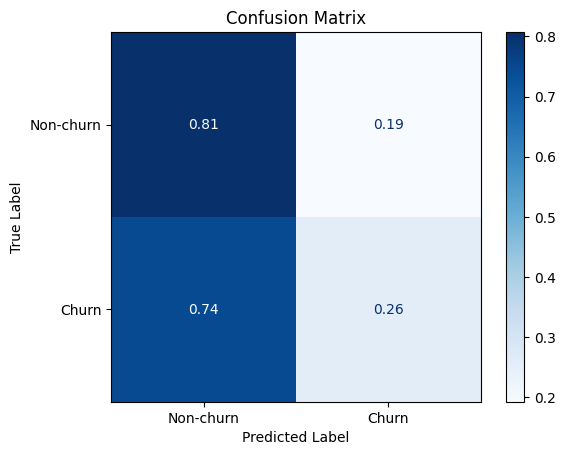

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, heuristic_predict, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Decision Tree

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(), CATEGORICAL_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', DecisionTreeClassifier(class_weight='balanced'))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['gym_days_since_first_visit',
                                                   'gym_last_60_days_visits',
                                                   'gym_visit_frequency',
                                                   'gyms_5km', 'months_usage',
                                                   'user_age', 'user_age_group',
                                                   'user_days_since_first_billing',
                                                   'user_days_since_first_gym_visit',
                                                   'user_days_since_first_visit',
                                                   'user_engagement',
                                                   'user_last_60_days_visit_share',
                                                   'user_last_60_days_visits',
                                                   'user_lifetime_visit_share',
                                                   'user_lifetime_visits',
                                                   'user_visit_frequency',
                                                   'years_usage']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gym_category',
                                                   'user_plan'])])),
                ('model', DecisionTreeClassifier(class_weight='balanced'))])

In [19]:
from collections import Counter
y_pred_class = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
print(y_pred_proba)
print(Counter(y_pred_class))
print(classification_report(y_test, y_pred_class))

[0. 0. 0. ... 0. 0. 0.]
Counter({0: 5407, 1: 941})
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      5343
           1       0.20      0.19      0.19      1005

    accuracy                           0.75      6348
   macro avg       0.52      0.52      0.52      6348
weighted avg       0.75      0.75      0.75      6348



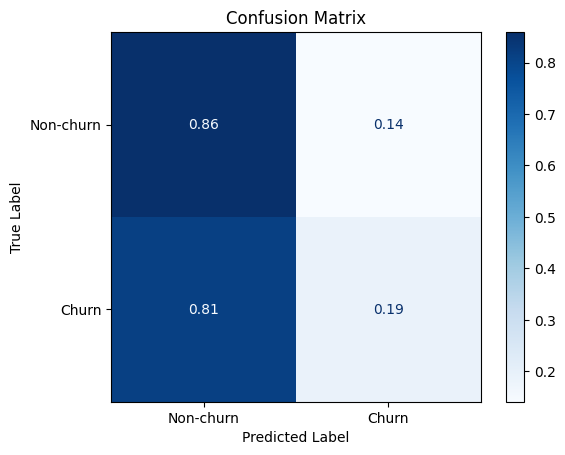

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
joblib.dump(y_pred_proba, "predictions/decision_tree_baseline.bin")

['predictions/decision_tree_baseline.bin']